**Mount Google Drive To Retrieve Data From Cloud Storage**

In [86]:
# Dataset: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Import Dependencies**

In [88]:
import numpy as np
import pandas as pd
import wordcloud
from matplotlib import pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

**Load and Display Cleaned STEMMED Data**

In [ ]:
# Load raw pre-cleaned data
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'
data = pd.read_csv(SAVE_PATH + 'data/Cleaned_IMDB_Dataset.csv')
data.review = data.review.astype(str)

print(data.head)
print("\n", data.shape)

<bound method NDFrame.head of                                                   review sentiment
0      one review mention watch oz episod youll hook ...  positive
1      wonder littl product film techniqu unassum old...  positive
2      thought wonder way spend time hot summer weeke...  positive
3      basic there famili littl boy jake think there ...  negative
4      petter mattei love time money visual stun film...  positive
...                                                  ...       ...
49995  thought movi right good job wasnt creativ orig...  positive
49996  bad plot bad dialogu bad act idiot direct anno...  negative
49997  cathol taught parochi elementari school nun ta...  negative
49998  im go disagre previou comment side maltin one ...  negative
49999  one expect star trek movi high art fan expect ...  negative

[50000 rows x 2 columns]>

 (50000, 2)


**Separate Review Text and Labels**

In [ ]:
x_vals = data['review'].values
y_vals = data['sentiment'].values
print("Review Text:\n------------\n", x_vals)
print("\nSentiment:\n----------\n", y_vals)

Review Text:
------------
 ['one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison e

**Use Text Vectorization Layer**

In [ ]:
VOCAB_SIZE = 1000
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE)
vectorizer.adapt(x_vals)

In [ ]:
vocab = np.array(vectorizer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'movie', 'film', 'one', 'like', 'good', 'even',
       'would', 'time', 'really', 'see', 'story', 'much', 'well', 'get',
       'great', 'bad', 'also', 'people'], dtype='<U14')

**Reshape Review Text**

In [ ]:
x_vals.resize((x_vals.shape[0], 1))
x_vals = np.asarray(x_vals).astype(np.str)

print(x_vals)
print("\n", x_vals.shape)

[['one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom c

**Reshape Sentiment Labels**

In [ ]:
# Convert positive labels to 1, negative to 0
y_vals[y_vals == 'positive'] = 1
y_vals[y_vals == 'negative'] = 0
y_vals.resize((y_vals.shape[0], 1))
y_vals = np.asarray(y_vals).astype(np.int)

print(y_vals)
print("\n", y_vals.shape)

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]

 (50000, 1)


**Partition Data**

In [ ]:
from sklearn.model_selection import train_test_split

# Randomize and split entire dataset into 80% train, 20% testing
x_train, x_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=.2, random_state=5)

print("Training:", x_train.shape, y_train.shape)
print("Testing:", x_test.shape, y_test.shape)


Training: (40000, 1) (40000, 1)
Testing: (10000, 1) (10000, 1)


**Build Model**

In [ ]:
model = Sequential([
    vectorizer,
    Embedding(
        input_dim=len(vectorizer.get_vocabulary()),
        output_dim=64,
        mask_zero=True      # Masking accounts for differing lengths
    ),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [ ]:
model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(1e-4),
    metrics=['accuracy']
)

**Train Model**

In [ ]:
# Pocket algorithm, save a checkpoint of model
# each time validation accuracy increases
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'
checkpoint = ModelCheckpoint(SAVE_PATH + 'GloVe_Bidirect_LSTM_stemmed', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Monitor whether validation loss decreased from last epoch, stop training
# if did not decrease in the last 2 epochs and restore weights to last decrease
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, restore_best_weights=True)

history = model.fit(
    x = x_train, 
    y = y_train, 
    validation_data = (x_test, y_test), 
    validation_steps=30,
    epochs = 10,
    callbacks=[checkpoint, es]
)

Epoch 1/10
1250/1250 [==============================] - 750s 592ms/step - loss: 0.6327 - accuracy: 0.5786 - val_loss: 0.4359 - val_accuracy: 0.8099

Epoch 00001: val_accuracy improved from -inf to 0.80990, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed/assets


Epoch 2/10
1250/1250 [==============================] - 733s 586ms/step - loss: 0.4179 - accuracy: 0.8051 - val_loss: 0.4032 - val_accuracy: 0.8170

Epoch 00002: val_accuracy improved from 0.80990 to 0.81700, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed/assets


Epoch 3/10
1250/1250 [==============================] - 734s 587ms/step - loss: 0.4037 - accuracy: 0.8096 - val_loss: 0.4003 - val_accuracy: 0.8213

Epoch 00003: val_accuracy improved from 0.81700 to 0.82130, saving model to gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed/assets


INFO:tensorflow:Assets written to: gdrive/MyDrive/Sentiment_Analysis/GloVe_Bidirect_LSTM_stemmed/assets


Epoch 4/10
1250/1250 [==============================] - 737s 590ms/step - loss: 0.3892 - accuracy: 0.8182 - val_loss: 0.3924 - val_accuracy: 0.8109

Epoch 00004: val_accuracy did not improve from 0.82130
Epoch 5/10
1250/1250 [==============================] - 734s 587ms/step - loss: 0.3909 - accuracy: 0.8179 - val_loss: 0.3931 - val_accuracy: 0.8075

Epoch 00005: val_accuracy did not improve from 0.82130
Epoch 6/10
1250/1250 [==============================] - 732s 585ms/step - loss: 0.3830 - accuracy: 0.8216 - val_loss: 0.3901 - val_accuracy: 0.8156

Epoch 00006: val_accuracy did not improve from 0.82130
Epoch 7/10
1250/1250 [==============================] - 745s 596ms/step - loss: 0.3839 - accuracy: 0.8211 - val_loss: 0.4017 - val_accuracy: 0.7875

Epoch 00007: val_accuracy did not improve from 0.82130
Epoch 8/10
1250/1250 [==============================] - 745s 596ms/step - loss: 0.3809 - accuracy: 0.8232 - val_loss: 0.3913 - val_accuracy: 0.8209

Epoch 00008: val_accuracy did not i

**Plot Training History**

In [ ]:
import json
SAVE_PATH = 'gdrive/MyDrive/Sentiment_Analysis/'

with open(SAVE_PATH + 'LSTM_single_stemmed_training.json', 'w') as file:
  json.dump(history.history, file)

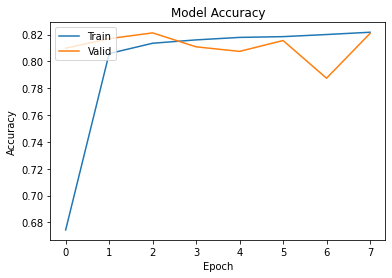

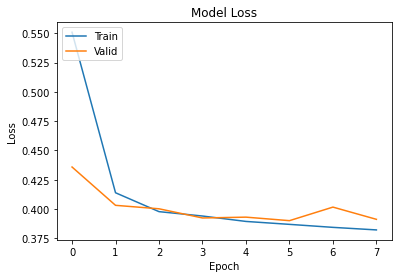

In [90]:
# Plot history of accuracy during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(SAVE_PATH + 'figures/acc_plot_single_stemmed.png')
plt.show()

# Plot history of loss during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig(SAVE_PATH + 'figures/loss_plot_single_stemmed.png')
plt.show()

**Load and Test Model**

In [98]:
model = load_model(SAVE_PATH + 'Single_LSTM_stemmed')
model.evaluate(x=x_vals, y=y_vals)
model.summary()

1563/1563 [==============================] - 196s 124ms/step - loss: 0.3949 - accuracy: 0.8256
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, None)              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


**Plot Confusion Matrix**

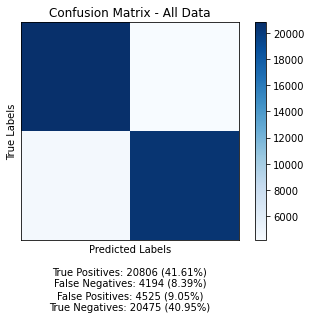

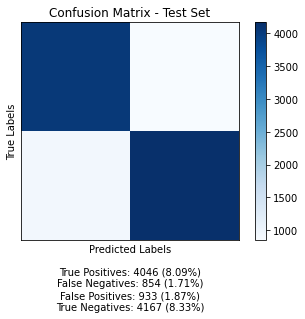

In [93]:
def get_caption(cm):
  return "\n\nTrue Positives: {} ({}%)\nFalse Negatives: {} ({}%)\nFalse Positives: {} ({}%)\nTrue Negatives: {} ({}%)".format(
    str(cm[0][0]), str(round((cm[0][0]/len(x_vals))*100, 2)),
    str(cm[0][1]), str(round((cm[0][1]/len(x_vals))*100, 2)),
    str(cm[1][0]), str(round((cm[1][0]/len(x_vals))*100, 2)),
    str(cm[1][1]), str(round((cm[1][1]/len(x_vals))*100, 2))
  )
  
# Generate predictions on full dataset
y_preds = model.predict(x_vals)
y_preds = np.where(y_preds > 0.5, 1, 0)
cm = confusion_matrix(y_vals, y_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion Matrix - All Data')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_alldata.png', bbox_inches='tight')
plt.show()


# Generate predictions on testing set
y_test_preds = model.predict(x_test)
y_test_preds = np.where(y_test_preds > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_test_preds)

# Plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels" + get_caption(cm))
plt.ylabel("True Labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion Matrix - Test Set')
plt.colorbar()
plt.savefig(SAVE_PATH + 'figures/confusion_matrix_testdata.png', bbox_inches='tight')
plt.show()

**Analyze Results**

In [94]:
# Display messages incorrectly classified
misclass_data = data.loc[y_preds != y_vals]
print("Stemmed Text Given to Model:\n", misclass_data)

# Display the unstemmed version of the misclassified messages
unstemmed_data = pd.read_csv(SAVE_PATH + 'data/Cleaned_No_Stemming_IMDB_Dataset.csv')
misclass_data_readable = unstemmed_data.loc[y_preds != y_vals]
print("\nHuman Readable Unstemmed Version of Text:\n", misclass_data_readable)

Stemmed Text Given to Model:
                                                   review sentiment
0      one review mention watch oz episod youll hook ...         1
3      basic there famili littl boy jake think there ...         0
7      show amaz fresh innov idea first air first yea...         0
9      like origin gut wrench laughter like movi youn...         1
11     saw movi came recal scariest scene big bird ea...         0
...                                                  ...       ...
49974  part michael disast ten minut charm nineti wor...         0
49975  minut mindymindi teas boyfriend billmindi pran...         0
49988  first tune morn news thought wow final enterta...         0
49993  robert colomb two fulltim job he known through...         0
49997  cathol taught parochi elementari school nun ta...         0

[8719 rows x 2 columns]

Human Readable Unstemmed Version of Text:
                                                   review sentiment
0      one reviewers mentioned

**Distribution of Misclassified Texts**

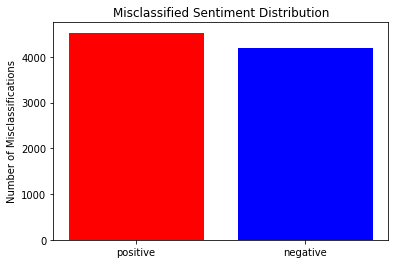

In [95]:
misclass_pos = misclass_data_readable[misclass_data_readable.sentiment == 'positive']
misclass_neg = misclass_data_readable[misclass_data_readable.sentiment == 'negative']

# Plot misclassified distribution
plt.bar(x=['positive', 'negative'], height=[misclass_pos.shape[0], misclass_neg.shape[0]], color=['red', 'blue'])
plt.title('Misclassified Sentiment Distribution')
plt.ylabel('Number of Misclassifications')
plt.savefig(SAVE_PATH + 'figures/misclassification_distr.png')
plt.show()

**Highest Frequency Words Among Misclassifications**

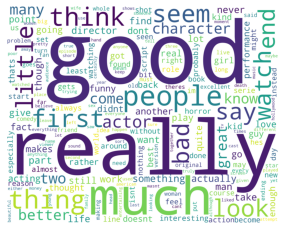

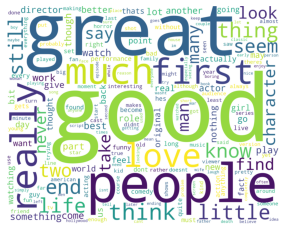

In [96]:
# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
misclass_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_pos['review'].values))
misclass_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(misclass_neg['review'].values))

# Display wordcloud images
plt.imshow(misclass_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(misclass_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
misclass_pos_wordcloud.to_file(SAVE_PATH + 'figures/misclass_pos_cloud.png')
misclass_neg_wordcloud.to_file(SAVE_PATH + 'figures/misclass_neg_cloud.png')

**Highest Frequency Words Among Correct Classifications**

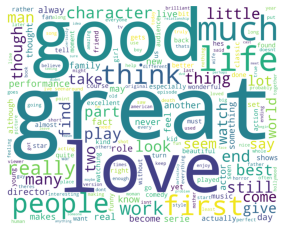

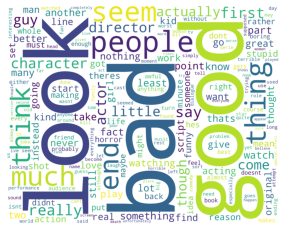

In [97]:
# Separate correctly classified data 
correct_data_readable = unstemmed_data.loc[y_preds == y_vals]
correct_pos = correct_data_readable[correct_data_readable.sentiment == 'positive']
correct_neg = correct_data_readable[correct_data_readable.sentiment == 'negative']

# Add domain specific stop words
exclude = list(wordcloud.STOPWORDS)
exclude.extend([
                    'film', 'films', 'one', 'movie', 'movies', 'characters', 'director'
                    'character', 'scene', 'scenes', 'story', 'time', 'show', 
                    'even', 'plot', 'make', 'made', 'see', 'well', 'way'
              ])
exclude = set(exclude)

# Generate wordcloud based on most common words in positive/negative reviews
correct_pos_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_pos['review'].values))
correct_neg_wordcloud = WordCloud(
                        stopwords=exclude,
                        background_color='white',
                        width=2500,
                        height=2000
                      ).generate(" ".join(correct_neg['review'].values))

# Display wordcloud images
plt.imshow(correct_pos_wordcloud)
plt.axis('off')
plt.show()
plt.imshow(correct_neg_wordcloud)
plt.axis('off')
plt.show()

# Save word clouds
correct_pos_wordcloud.to_file(SAVE_PATH + 'figures/correct_pos_cloud.png')
correct_neg_wordcloud.to_file(SAVE_PATH + 'figures/correct_neg_cloud.png')

**Excerpts of Misclassified Text**

In [ ]:
import textwrap
import random

# Separate data
misclass_pos_text = misclass_pos['review'].values
misclass_neg_text = misclass_neg['review'].values

# Display excerpts of texts in dataset that were misclassified
# Typically include both positive and negative remarks in review
def underline(text): return text + '\n' + ('-' * len(text))

print(underline("Postive Labeled Reviews Predicted Negative:"), "\n")
for i in [90, 164]:
  print(textwrap.fill(misclass_pos_text[i], 75), "\n")

print(underline("Negative Labeled Reviews Predicted Positive:"), "\n")
for i in [66, 551]:
  print(textwrap.fill(misclass_neg_text[i], 75), "\n")

Postive Labeled Reviews Predicted Negative:
------------------------------------------- 

worst movie ive ever seen yet also best movie sci fi original movies
supposed bad thats makes fun line like dinosaur meat well done probably
best quote ever also plot sounds like something pot induced dream imagine
writers waking long night getting high playing dance dance revolution
putting ideas together space marines got alien planet infested dinosaurs
medieval houses protect science team studying planet best idea ever fact
fits complete sci fi original movie checklist guns dinosaurs medieval times
space travel terrible actingso go watch movie dont buy 

without kirsten miller project neednt completed however awe inspiring
beauty talent miss miller would definitely recommend looked actors playing
strong performance wagners dismal attempt honor film bit disappointing
scenes didnt detract entertained mostly criticisms writing plot line group
talent assembled heroic job salvaging disaster charisma